## Examples

In [4]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from itertools import combinations 
from anomaly_detection import pca, plot_pcs, optimize_condition, plot_pie
from anomaly_detection import plot_radar, diff_normalize, plot_barh, describe_y, outliers

In [5]:
from sklearn.datasets import load_breast_cancer as data
X, y = data(return_X_y=True)
X = pd.DataFrame(X, columns=[s.replace(' ','_') for s in data().feature_names]).iloc[:,:20]

<font color='#0652DD'> 
In this example, we are dealing with high dimensional data, using `Principal Component Analysis` (`PCA`) helps reduce number of variables (dimensionality reduction) by performing a linear mapping (`eigenvector`) to a lower-dimensional space.
</font>

# <font color='#0652DD' size=3.5>( 1 ) Determine number of `Principal Components`.</font>

Output :
- pc_df : `pd.DataFrame` object of principal components.
- loadings : `pd.DataFrame` object of `eigenvector`.
- var : list of variables that pass `vec_cutoff`.

In [6]:
pc_df, loadings, _, var = pca(X, vec_cutoff=0.3)

In [7]:
pc_df.sample(5)

,PC01,PC02,PC03,PC04
551,0.847553,0.191148,-0.770651,-0.105470
187,0.090512,1.247765,-0.051104,0.914105
483,0.859232,0.637295,-1.046128,0.612486
540,-0.310065,0.727677,2.055668,0.181112
191,0.043403,-0.165650,-0.943978,0.410907


# <font color='#0652DD' size=3.5>( 2 ) Anomaly detection.</font>

### Isolation Forest
- For this example, `IsolationForest` from `sklearn.ensemble` is selected.
- Prediction array is comprised of `0` for `normal`, `1` for `anomaly`.

---
The `IsolationForest` isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. 
Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of such random trees, is a measure of normality.

- The anomaly score $s$ of an instance $x$ is defined as:
    - $s(x,n) = 2^{-\frac{E(h(x)}{c(n)}}$
    
    
- Path Length $h(x)$ of a point $x$ is measured by the number of edges $x$ traverses an iTree from the root node.
- $c(n)$ is the average path length of iTree or the average of $h(x)$ given $n$, which can be expressed as:
    - $c(n)$ = $2H(n − 1) − \frac{2(n − 1)}{n})$
    - $H(i)$ is the harmonic number and it can be estimated by $H(i) ≈\log(i) + 0.5772156649$ (Euler’s constant)
    - $H_{n}=1+{\frac{1}{2}}+{\frac {1}{3}}+\cdots +{\frac {1}{n}}=\sum _{k=1}^{n}{\frac {1}{k}}$ 


- when $E(h(x))$ $\Longrightarrow$ $c(n)$, $s$ $\Longrightarrow$ 0.5
- when $E(h(x))$ $\Longrightarrow$ 0, $s$ $\Longrightarrow$ 1;
- when $E(h(x))$ $\Longrightarrow$ $n$−1, $s$ $\Longrightarrow$ 0.

---
Using the anomaly score $s$, we are able to make the following assessment:

- (a) if instances return $s$ very close to 1, then they are definitely anomalies,
- (b) if instances have $s$ much smaller than 0.5, then they are quite safe to be regarded as normal instances, and
- (c) if all the instances return $s$ ≈ 0.5, then the entire sample does not really have any distinct anomaly.

It is noteworthy that anomaly socre from `sklearn.ensemble.IsolationForest` doesn't follow the same calculation as stated in original paper i.e. $s(x,n)_{sklearn} = 0.5 - s(x,n)_{original}$.

---
Reference : 
- [Isolation Forest](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)
- [scikit-learn-isolationforest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) 
- [scikit-learn-isolationforest-anomaly-score](https://stats.stackexchange.com/questions/335274/scikit-learn-isolationforest-anomaly-score)

In [8]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(n_estimators=500, random_state=0, behaviour='new', contamination='auto')
y_if = np.where(IF.fit_predict(pc_df)==-1,1,0)
if_score = 0.5 + abs(IF.score_samples(pc_df))
if_cutoff = if_score[y_if==1].min()

In [9]:
def plot_score(score, y, cutoff, title, bins=30):
    
    hist, bins = np.histogram(score, bins=bins)
    c = lambda y,n : (y==n).sum()
    p = lambda y,n : c(y,n)/len(y)
    s = lambda y,n : ' ({:,.4g}, {:.2%})'.format(c(y,n),p(y,n))
    plt.hist(score[y==0], bins=bins, color='#10ac84', label='normal' + s(y,0))
    plt.hist(score[y==1], bins=bins, color='#ee5253', label='anomaly' + s(y,1))
    plt.title(title, fontweight='bold')
    label = r'cutoff$_{LOF}$ '+'({:,.4g})'.format(cutoff)
    plt.axvline(cutoff, lw=1, ls='--', color='k', label=label)
    plt.legend(loc='best', framealpha=0, fontsize=10)
    plt.show()

Let's see where `IsolationForest` defines `cutoff` for `anomaly` (`contamination`='auto').

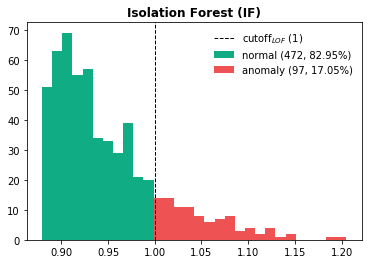

In [10]:
plot_score(if_score, y_if, if_cutoff, 'Isolation Forest (IF)')

Use `outlier` to determine `cutoff` (method = `gamma`) and observe difference between.

In [11]:
model = outliers(method='gamma')
model.fit(pd.DataFrame({'score':if_score}))

c = model.limit_['upper'][0]; n = (if_score>=c).sum()
s = 'Cutoff = {:.4f} ==> Number of anomalies = {:,.4g} ({:.0%})'
print(s.format(c, n, n/len(if_score)))

Cutoff = 1.1055 ==> Number of anomalies = 12 (2%)


### LocalOutlierFactor
Alternatively, we can use `LocalOutlierFactor` from `sklearn.neighbors`.

---
The [LocalOutlierFactor](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest) (LOF) algorithm computes a score (called local outlier factor) reflecting the degree of abnormality of the observations. It measures the local density deviation of a given data point with respect to its neighbors. The idea is to detect the samples that have a substantially lower density than their neighbors.

Reference : `scikit-learn.org`

- $k^{th}$ neighbour of $x$
- `Averge Reachability distance` of $x$ $\Longrightarrow$ $ARD(x)$ = $\frac{1}{k}\sum_{i=1}^{k}max(d_{i,k},d_{i,x})$
- $d_{i,k}$ is the $k^{th}$ nearest distance to $i$, $d_{i,x}$ is the distance between $i$, and $x$ and $k$ is a number of neighbour.
- `Local Reachability distance` of $x$ $\Longrightarrow$ $LRD(x)$ = $\frac{1}{ARD(x)}$
- `Local Outlier Factor` of $x$ $\Longrightarrow$ LOF($x$) = $\frac{\frac{1}{k}\sum_{i=1}^{k}LRD(i)}{LRD(x)}$

In [12]:
from sklearn.neighbors import LocalOutlierFactor

LOF = LocalOutlierFactor(n_neighbors=100, contamination='auto')
y_lof = np.where(LOF.fit_predict(pc_df)==-1,1,0)
lof_score = -LOF.negative_outlier_factor_
lof_cutoff = lof_score[y_lof==1].min()

Let's see where `LocalOutlierFactor` defines `cutoff` for `anomaly` (`contamination`='auto').

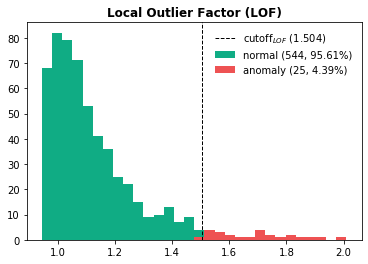

In [13]:
plot_score(lof_score, y_lof, lof_cutoff, 'Local Outlier Factor (LOF)')

In [14]:
model = outliers(method='gamma')
model.fit(pd.DataFrame({'score':lof_score}))

c = model.limit_['upper'][0]; n = (lof_score>=c).sum()
s = 'Cutoff = {:.4f} ==> Number of anomalies = {:,.4g} ({:.0%})'
print(s.format(c, n, n/len(lof_score)))

Cutoff = 1.4471 ==> Number of anomalies = 36 (6%)


# <font color='#0652DD' size=3.5>( 3 ) Result analysis.</font>

### <font color='#e84118' size=4> Decision required </font>
- Select result of `anomaly` from available model predictions.
- Define `keyword argument` for plot.

In [15]:
anomaly = y_if.copy()
plot_kwargs = dict(labels=['Normal','Anomaly'], colors=['#009432','#EA2027'])

- Pie chart represents proportion of 2 classes, which are `normal` and `anomaly`.
- The amount of `anomaly` is varied by which algorithm is used.

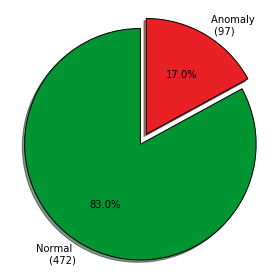

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
plot_pie(ax, anomaly, **plot_kwargs)
fig.tight_layout()
plt.show()

- Visaulize `Principal Component` in pair and see how `feature` in `eigenvector` influence the spred or cluster of data.

In [17]:
# Number of columns.
n_col = 3; cutoff = 0.4

# Combination of Principal Components.
pairs = list(combinations(np.arange(pc_df.shape[1])+1, 2))

# Number of rows --> Calculate from number of pairs and `n_col`
n_row = np.ceil(len(pairs)/n_col).astype(int); n_pairs = len(pairs)

# Define `loc` (x,y) for each `plt.subplot`.
locs = [(r,c) for r in range(n_row) for c in range(n_col)][:n_pairs]

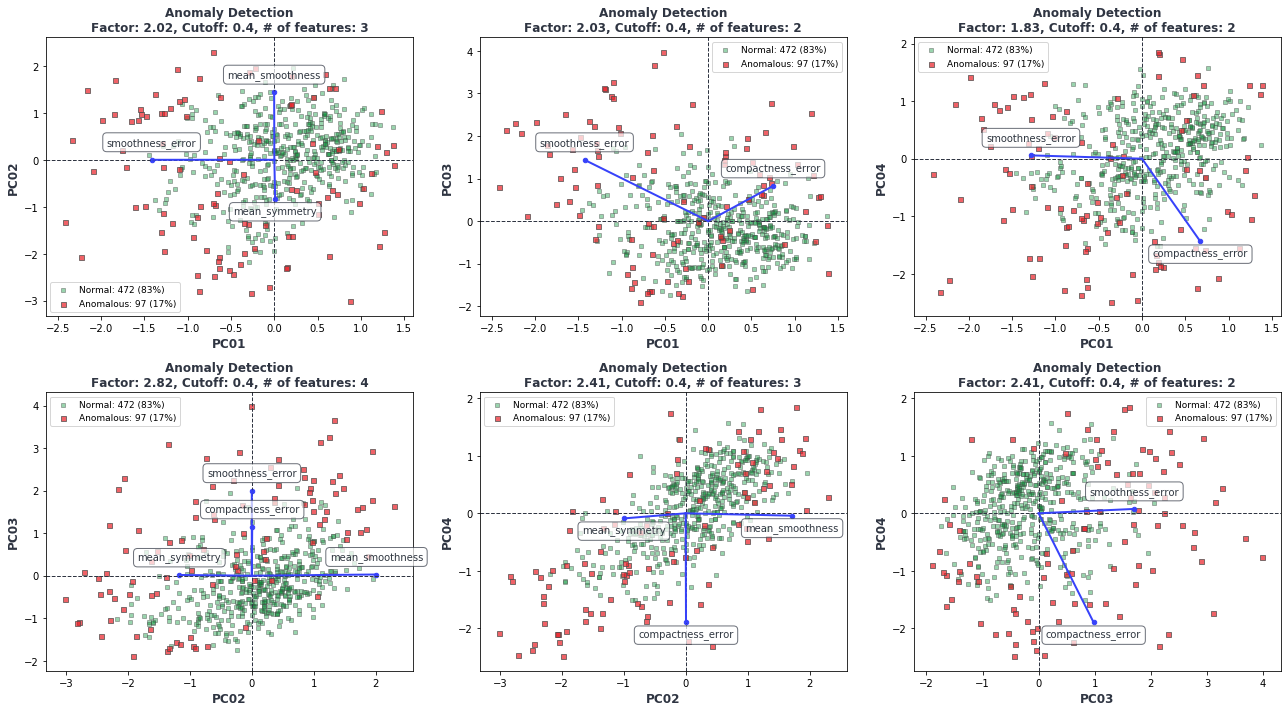

In [18]:
# Create figure and plots.
fig = plt.figure(figsize=(n_col*6, n_row*5))
axes = [plt.subplot2grid((n_row, n_col),loc) for loc in locs]
    
# Plot all combination of PCs.
for (ax,pc) in zip(axes, pairs):
    kw = dict(pc=pc, cutoff=cutoff)
    plot_pcs(ax, anomaly, pc_df, loadings, **kw)
fig.tight_layout()
plt.show()

<font color='#0652DD'> 
Although, using `Principal Component` might yield better result (due to scaling effect, `eigenvalue`), yet it is farily difficult when it comes to explanation. To avoid such confusion, we could try to use normal features instead. </font>

---

- Find the difference of normalized values between `normal` and `anomaly` by features. This helps enable the comparison across features.
- `difference` can be viewed as a distance between two distributions from any nth-percentile of interests (`q1`).
- This returns array of `difference` by features as well as `cutoff` given nth-percentile (`q2`)

In [19]:
difference, cutoff = diff_normalize(X, anomaly, q1=50, q2=60)

- Visualize the `difference` and see how many features make the cutoff. 
- The `scree plot`, that is used to determine the number of factors e.g. `Principal Component`, is also applicable to determine number of features.

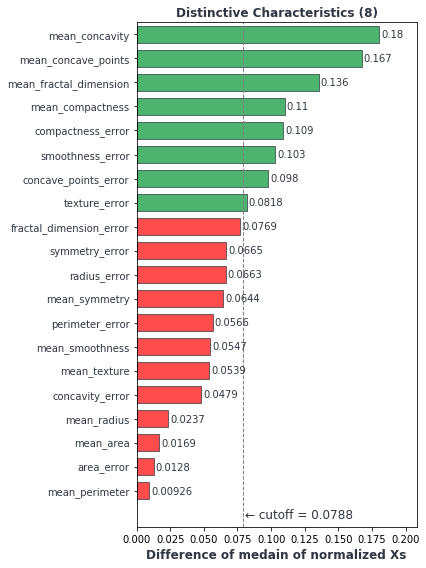

In [20]:
fig, ax = plt.subplots(figsize=(6,8))
features = np.array(list(X))[difference[:,-1].astype(int)]
plot_barh(ax, features, difference[:,0], cutoff)
fig.tight_layout()
plt.show()

<font color='#0652DD'> There are 8 variables that make the cutoff. These variables clearly illustrate the gap between two distributions. </font>

---

### <font color='#e84118' size=4> Decision required </font>
- Select number of features (`variable`).

In [21]:
# To manually define numver of variables.
#n_features = 8; variable = features[:n_features]
# Automatically select variable above cutoff.
variable = features[:(difference[:,0]>=cutoff).sum()]

- Plot `variable` that make distinct difference (distance) between `normal` and `anomaly` distributions. 
- This provides an overview of how `normal` and `anomaly` differ from one another by prominent features.

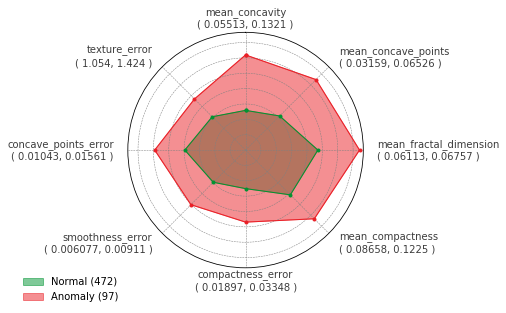

In [22]:
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(polar=True)
plot_radar().fit(ax, X[variable], anomaly, **plot_kwargs)
fig.tight_layout()
plt.show()

<font color='#0652DD'> 
Alternatively, we can compute descriptive statistics (similarly to `pd.DataFrame.describe`) to observe e.g. the central tendency, dispersion and shape of distribution. This enables us to identify which `variable` that clearly separate `anomaly` from `normal`. 
    
For this example, we are using function called `describe_y` to determine any statistical values of our interests. The applicable `aggregating function` inputs is either `numpy` based or any function that implements the same interface.
</font>

In [23]:
# Function to use for aggregating the data.
def pct(n): 
    def nan_pct(x): return np.nanpercentile(x, n)
    nan_pct.__name__ = 'pct_{}'.format(n) 
    return nan_pct

def iqr():
    p = lambda x : np.nanpercentile(x, [25,75])
    def nan_iqr(x): return np.diff(p(x))
    nan_iqr.__name__ = 'IQR'
    return nan_iqr

In [24]:
fnc = [pct(n) for n in range(0,101,25)] + [iqr(), np.mean, np.std]
stats = describe_y(X[variable], np.where(anomaly==0,'normal','anomaly'), fnc)
stats.loc[stats.index.get_level_values('feature').isin(variable[:2])]

pct_0    pct_25    pct_50    pct_75 pct_100  \
feature             flag                                                  
mean_concavity      anomaly     0   0.03649    0.1321    0.2136  0.4268   
                    normal      0  0.028745   0.05513  0.111675  0.3368   
mean_concave_points anomaly     0   0.02076   0.06526    0.1021  0.2012   
                    normal      0    0.0203  0.031585   0.06503  0.1913   

                                 IQR       mean        std  
feature             flag                                    
mean_concavity      anomaly  0.17711   0.142013   0.115158  
                    normal   0.08293  0.0778634  0.0652542  
mean_concave_points anomaly  0.08134  0.0689504  0.0530994  
                    normal   0.04473  0.0448025  0.0337852

<font color='#0652DD'> 
Sometimes establishing a simple rule-based cutoff comes in handy as it provides an easy-to-understand limit, where data that lies beyond this point is identified as `anomaly`, as opposed to model that requires more effort to explain. 

In this example, `optimize_condition` is deployed to optimize the combination of `variable` that maximize `f1-score`. 
    
</font>

In [25]:
criteria = optimize_condition(X[variable].copy(), anomaly.copy(), n_max=1000)

In [26]:
criteria

{'criteria': [['smoothness_error', '≥', 0.01097],
  ['compactness_error', '≥', 0.04674],
  ['mean_compactness', '≥', 0.2106]],
 'confusion_matrix': [439, 26, 33, 71],
 'f1_score': 0.7065}

### The interpretation of results

<font color='#0652DD'>
    
---    
- Data is identified as `anomaly` when it satisfies one of the following criteria in `cascading` manner:

|Order|   Confusion Matrix  | Criteria | 
|:---:|:-------------------:|:--------:|
|  1  |**smoothness_error** | ≥0.01097 |
|  2  |**compactness_error**| ≥0.04674 | 
|  3  |**mean_compactness** | ≥0.21060 |
    
- `confusion_matrix` is determined by obtained criteria. Its elements are arranged in the following manner:

|Confusion Matrix  |  N | 
|:----------------:|---:|
|**True Negative** | 441|
|**False Negative**|  21| 
|**False Positive**|  31|
|**True Negative** |  73|

</font>